In [179]:
from skimage import io
import numpy as np

from skimage.feature import canny
from skimage.transform import probabilistic_hough_line

import matplotlib.pyplot as plt
from matplotlib import cm

In [210]:
def normalize_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi


def get_dist(p0, p1):
    return np.linalg.norm([p1[0] - p0[0], p1[1] - p0[1]])


def get_dist_to_line(p, l):
    p0, p1 = l
    (px, py), (p0x, p0y), (p1x, p1y) = p, p0, p1 
    return np.abs((p1y - p0y) * px - (p1x - p0x) * py + p1x * p0y - p0x * p1y) / get_dist(p0, p1)


def get_side_of_line(p, l):
    p0, p1 = l
    return np.sign((p[0] - p0[0]) * (p1[1] - p0[1]) - (p[1] - p0[1]) * (p1[0] - p0[0]))


def get_angle(p0, p1):
    (p0x, p0y), (p1x, p1y) = p0, p1
    return np.arctan((p1y - p0y) / ((p1x - p0x) if (p1x - p0x) != 0 else 1e-9))


def get_angle_between_lines(l0, l1):
    v0x, v0y = l0[1][0] - l0[0][0], l0[1][1] - l0[0][1]
    v1x, v1y = l1[1][0] - l1[0][0], l1[1][1] - l1[0][1]
    return np.arccos((v0x * v1x + v0y * v1y) / (get_dist(l0[0], l0[1]) * get_dist(l1[0], l1[1])))


def get_intersection(l0, l1):
    (p00x, p00y), (p01x, p01y) = l0
    (p10x, p10y), (p11x, p11y) = l1
    denominator = (p00x - p01x) * (p10y - p11y) - (p00y - p01y) * (p10x - p11x)
    if denominator == 0:
        return None
    ix = ((p00x * p01y - p00y * p01x) * (p10x - p11x) - (p10x * p11y - p10y * p11x) * (p00x - p01x)) / denominator
    iy = ((p00x * p01y - p00y * p01x) * (p10y - p11y) - (p10x * p11y - p10y * p11x) * (p00y - p01y)) / denominator
    return ix, iy


def check_clockwise_order(points):
    p0, p1, p2, p3 = points
    direction = get_side_of_line(p2, (p0, p1))
    for pi, pj, pk in ((p1, p2, p3), (p2, p3, p0), (p3, p0, p1)):
        if get_side_of_line(pk, (pi, pj)) != direction:
            return False
    return True

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in arccos


((833, 1486), (905.6928236377187, 245.1738854061637), (1046.630203362455, 189.5407091990309), (1133, 1223))
((1959, 1386), (1960.1244444444444, 1133.0), (1960.1244444444444, 1133.0), (1959, 1386))
((869.3464118188593, 217.35729730259732), (1089.8151016812276, 217.35729730259732), (1089.8151016812276, 1354.5), (869.3464118188593, 1354.5))
((1959.0, 1133.0), (1960.1244444444444, 1133.0), (1960.1244444444444, 1386.0), (1959.0, 1386.0))


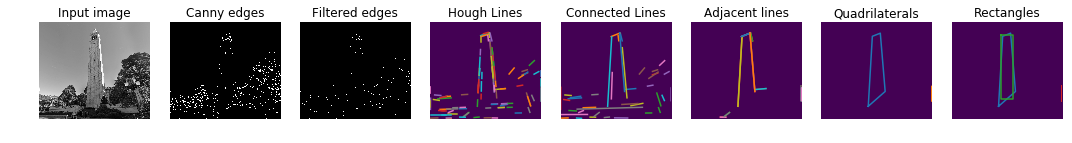

In [222]:
image_addr = "/Users/yitengzhang/Desktop/campanile.png"


canny_sigma = 1
canny_low, canny_high = 0.9, 0.95

hough_threshold = 25
hough_min_length, hough_max_gap = 80, 20


def filter_edges(edges):
    h, w = edges.shape
    to_fill = np.zeros((h, w), dtype=bool)
    for i in range(3, h - 3):
        for j in range(3, w - 3):
            if edges[i, j] and (np.sum(edges[i - 3:i + 4, j - 3:j + 4]) > 10):
                to_fill[i, j] = 1
    for i in range(5, h - 5):
        for j in range(5, w - 5):
            if edges[i, j] and (np.sum(edges[i - 5:i + 6, j - 5:j + 6]) > 20):
                to_fill[i, j] = 1
    return edges ^ to_fill


def connect_lines(lines, angle_threshold=np.pi / 12, line_dist_threshold=10, point_dist_threshold=1):
    lines_to_angles = {(p0, p1): get_angle(p0, p1) for p0, p1 in lines}
    redo = True
    while redo:
        redo = False
        sorted_lines = sorted([*lines_to_angles.keys()], key=lambda l: get_dist(*l))
        for l0 in sorted_lines:
            for l1 in sorted_lines:
                if l1 != l0 and np.abs(lines_to_angles[l0] - lines_to_angles[l1]) < angle_threshold:
                    center = np.mean([*l0, *l1], axis=0)
                    if all(get_dist_to_line(center, l) < line_dist_threshold for l in (l0, l1)):
                        if all(min(get_dist(center, p) / get_dist(*l) for p in l) < point_dist_threshold for l in (l0, l1)):
                            far0 = l0[1] if get_dist(center, l0[0]) < get_dist(center, l0[1]) else l0[0]
                            far1 = l1[1] if get_dist(center, l1[0]) < get_dist(center, l1[1]) else l1[0]
                            del lines_to_angles[l0]
                            del lines_to_angles[l1]
                            lines_to_angles[far0, far1] = get_angle(far0, far1)
                            redo = True
                            break
            if redo:
                break
    return [*lines_to_angles.keys()]


def find_adjacent_lines(lines, dist_threshold=50, angle_bound=(np.pi / 6, np.pi / 6 * 5)):
    adjacent_lines = {l: [[], []] for l in lines}
    for l0 in lines:
        for i, p0 in enumerate(l0):
            for l1 in lines:
                for j, p1 in enumerate(l1):
                    if get_dist(p0, p1) < dist_threshold and angle_bound[0] <= np.abs(get_angle_between_lines(l0, l1)) <= angle_bound[1]:
                        adjacent_lines[l0][i].append((l1, j))
                        break
    return adjacent_lines


def form_quadrilaterals(adjacent_lines, dl_threshold=200):
    all_quadrilaterals = set()
    for l in adjacent_lines:
        line_quadrilaterals = set()
        for l_l, i_l in adjacent_lines[l][0]:
            for l_ll, i_ll in adjacent_lines[l_l][1 - i_l]:
                for l_r, i_r in adjacent_lines[l][1]:
                    for l_rr, i_rr in adjacent_lines[l_r][1 - i_r]:
                        if l_ll == l_rr != l:
                            if all(get_intersection(l0, l1) is not None for l0, l1 in ((l, l_l), (l, l_r), (l_ll, l_l), (l_ll, l_r))):
                                points = [get_intersection(l0, l1) for l0, l1 in ((l, l_l), (l, l_r), (l_ll, l_l), (l_ll, l_r))]
                                if check_clockwise_order(points):
                                    line_quadrilaterals.add(tuple(points))
        if not line_quadrilaterals:
            for l_l, i_l in adjacent_lines[l][0]:
                for l_r, i_r in adjacent_lines[l][1]:
                    if np.abs(get_dist(*l_l) - get_dist(*l_r)) < dl_threshold:
                        if all(get_intersection(l0, l1) is not None for l0, l1 in ((l, l_l), (l, l_r))):
                            points = [l_l[1 - i_l]] + [get_intersection(l0, l1) for l0, l1 in ((l, l_l), (l, l_r))] + [l_r[1 - i_r]]
                            if check_clockwise_order(points):
                                line_quadrilaterals.add(tuple(points))
        all_quadrilaterals |= line_quadrilaterals
    return all_quadrilaterals


def quadrilateral_to_rectangle(quadrilateral):
    xs = sorted([p[0] for p in quadrilateral])
    ys = sorted([p[1] for p in quadrilateral])
    xl, xr = np.mean([xs[:2]]), np.mean([xs[2:]])
    yt, yb = np.mean([ys[:2]]), np.mean([ys[2:]])
    return ((xl, yt), (xr, yt), (xr, yb), (xl, yb))
    
    
image = io.imread(image_addr, as_gray=True)
edges = canny(image, canny_sigma, canny_low, canny_high, use_quantiles=True)
filtered_edges = filter_edges(edges)
    
lines = probabilistic_hough_line(filtered_edges, hough_threshold, hough_min_length, hough_max_gap)
connected_lines = connect_lines(lines)
adjacent_lines = find_adjacent_lines(connected_lines)
quadrilaterals = form_quadrilaterals(adjacent_lines)
rectangles = [quadrilateral_to_rectangle(q) for q in quadrilaterals]


fig, axes = plt.subplots(1, 8, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(filtered_edges, cmap=cm.gray)
ax[2].set_title('Filtered edges')

ax[3].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[3].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[3].set_xlim((0, image.shape[1]))
ax[3].set_ylim((image.shape[0], 0))
ax[3].set_title('Hough Lines')

ax[4].imshow(edges * 0)
for line in connected_lines:
    p0, p1 = line
    ax[4].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[4].set_xlim((0, image.shape[1]))
ax[4].set_ylim((image.shape[0], 0))
ax[4].set_title('Connected Lines')

ax[5].imshow(edges * 0)
for line in adjacent_lines:
    exists_nearby = False
    for direction in adjacent_lines[line]:
        for nearby_line, _ in direction:
            p0, p1 = nearby_line
            ax[5].plot((p0[0], p1[0]), (p0[1], p1[1]))
            exists_nearby = True
    if exists_nearby:
        p0, p1 = line
        ax[5].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[5].set_xlim((0, image.shape[1]))
ax[5].set_ylim((image.shape[0], 0))
ax[5].set_title('Adjacent lines')

ax[6].imshow(edges * 0)
for quadrilateral in quadrilaterals:
    ax[6].plot([p[0] for p in quadrilateral] + [quadrilateral[0][0]], [p[1] for p in quadrilateral] + [quadrilateral[0][1]])
ax[6].set_xlim((0, image.shape[1]))
ax[6].set_ylim((image.shape[0], 0))
ax[6].set_title('Quadrilaterals')

ax[7].imshow(edges * 0)
for quadrilateral in quadrilaterals:
    print(quadrilateral)
    ax[7].plot([p[0] for p in quadrilateral] + [quadrilateral[0][0]], [p[1] for p in quadrilateral] + [quadrilateral[0][1]])
for rectangle in rectangles:
    print(rectangle)
    ax[7].plot([p[0] for p in rectangle] + [rectangle[0][0]], [p[1] for p in rectangle] + [rectangle[0][1]])
ax[7].set_xlim((0, image.shape[1]))
ax[7].set_ylim((image.shape[0], 0))
ax[7].set_title('Rectangles')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()